In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Datasets

In [2]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

# Data Preprocessing

## Convert date columns to datetime format

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

## Merge datasets

In [4]:
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays_events, on='date', how='left')

test = test.merge(stores, on='store_nbr', how='left')
test = test.merge(oil, on='date', how='left')
test = test.merge(holidays_events, on='date', how='left')

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [6]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [7]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(0, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(0, inplace=True)

# Exploratory Data Analysis (EDA)

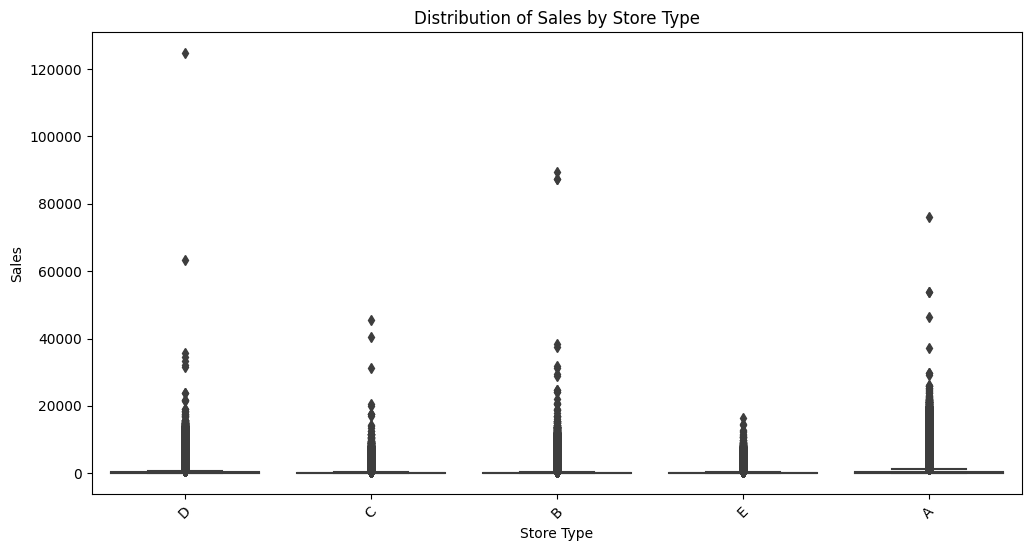

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type_x', y='sales', data=train)
plt.title('Distribution of Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_24/63390182.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='month_year', y='sales', data=train, estimator=np.mean, ci=None)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


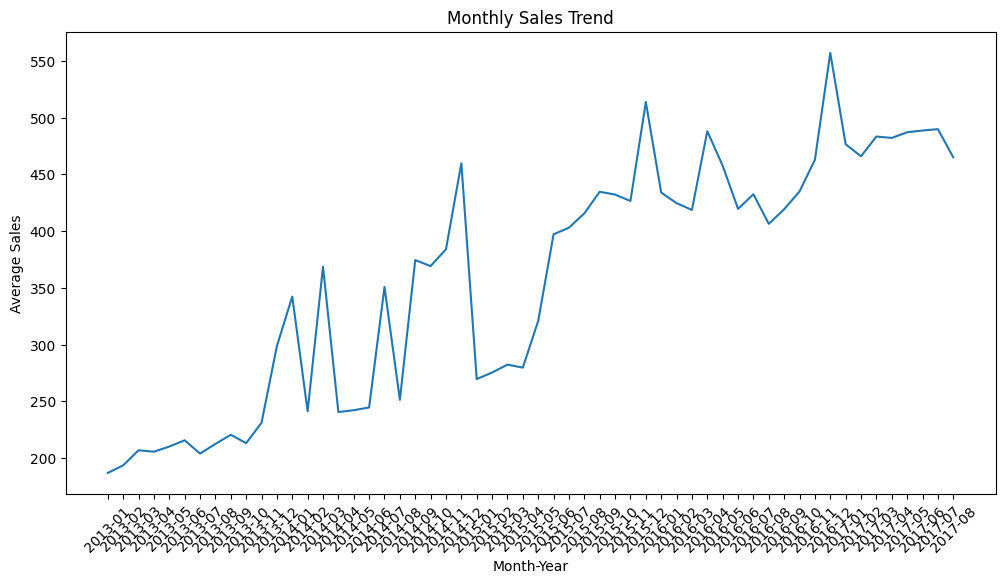

In [9]:
train['month_year'] = train['date'].dt.to_period('M').astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='month_year', y='sales', data=train, estimator=np.mean, ci=None)
plt.title('Monthly Sales Trend')
plt.xlabel('Month-Year')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()


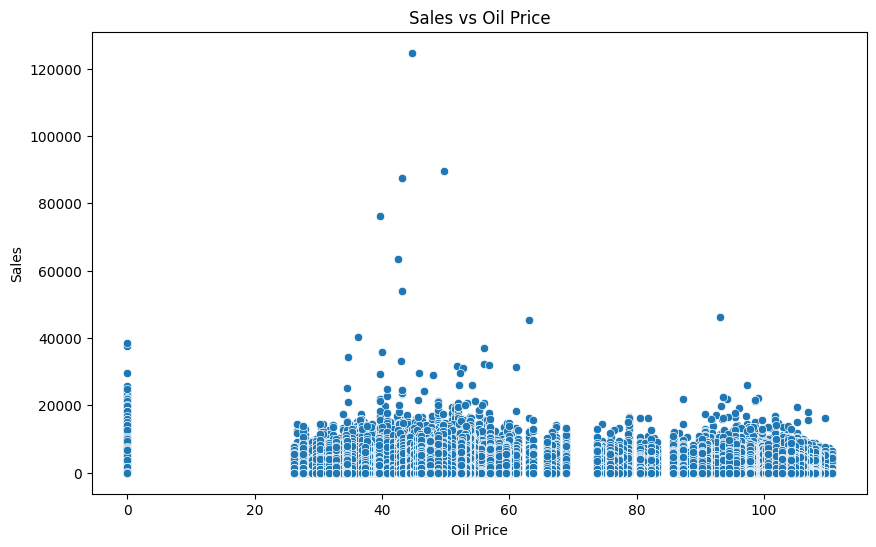

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train)
plt.title('Sales vs Oil Price')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()


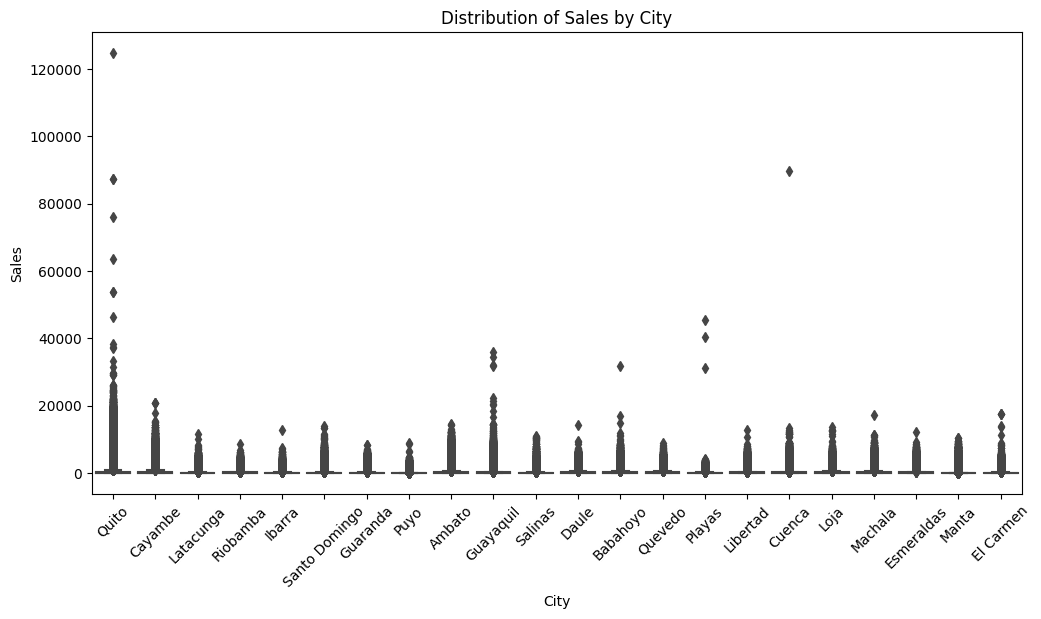

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='sales', data=train)
plt.title('Distribution of Sales by City')
plt.xlabel('City')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_24/659892947.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='transferred', y='sales', data=train, estimator=np.mean, ci=None)


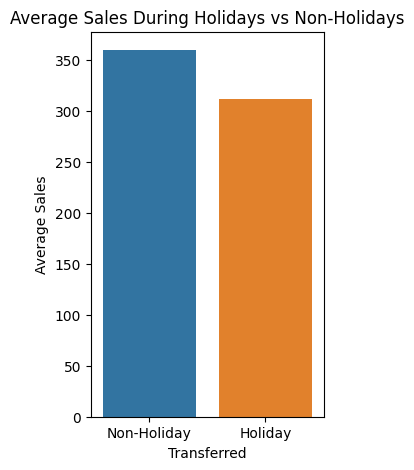

In [12]:
plt.figure(figsize=(3, 5))
sns.barplot(x='transferred', y='sales', data=train, estimator=np.mean, ci=None)
plt.title('Average Sales During Holidays vs Non-Holidays')
plt.xlabel('Transferred')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()


# Feature Engineering

In [13]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [14]:
# Create time-based features
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day'] = train['date'].dt.day

test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['day'] = test['date'].dt.day

In [15]:
# Define features and target
features = [col for col in train.columns if col not in ['date', 'sales']]
target = 'sales'

In [16]:
# Remove outliers using boxplot
Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train = train[(train['sales'] >= lower_bound) & (train['sales'] <= upper_bound)]

## Encoding Categorical Variables

In [17]:
# Encoding Categorical Variables
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['store_nbr', 'family', 'city', 'state', 'cluster', 'type_x', 'type_y', 'locale_name', 'description', 'transferred', 'locale']

# Convert all values in categorical columns to strings and then apply label encoding
for column in categorical_columns:
    train[column] = train[column].astype(str)
    test[column] = test[column].astype(str)
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.transform(test[column])

# Display basic information about the datasets after preprocessing
print("\nTrain Data After Preprocessing:")
print(train.info())
print("\nTest Data After Preprocessing:")
print(test.info())


Train Data After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 2598842 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       int64         
 4   sales        float64       
 5   onpromotion  int64         
 6   city         int64         
 7   state        int64         
 8   type_x       int64         
 9   cluster      int64         
 10  dcoilwtico   float64       
 11  type_y       int64         
 12  locale       int64         
 13  locale_name  int64         
 14  description  int64         
 15  transferred  int64         
 16  month_year   object        
 17  day_of_week  int32         
 18  month        int32         
 19  year         int32         
 20  day          int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(13), object(1)
memory usage: 396.6+ MB
None



In [18]:
# Ensure all columns are numeric
for column in train.columns:
    if train[column].dtype == 'object':
        print(f"Warning: Column '{column}' is still object type")

In [19]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,type_y,locale,locale_name,description,transferred,month_year,day_of_week,month,year,day
0,0,2013-01-01,0,0,0.0,0,18,12,3,4,...,4,2,5,51,1,2013-01,1,1,2013,1
1,1,2013-01-01,0,1,0.0,0,18,12,3,4,...,4,2,5,51,1,2013-01,1,1,2013,1
2,2,2013-01-01,0,2,0.0,0,18,12,3,4,...,4,2,5,51,1,2013-01,1,1,2013,1
3,3,2013-01-01,0,3,0.0,0,18,12,3,4,...,4,2,5,51,1,2013-01,1,1,2013,1
4,4,2013-01-01,0,4,0.0,0,18,12,3,4,...,4,2,5,51,1,2013-01,1,1,2013,1


In [20]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,day_of_week,month,year,day
0,3000888,2017-08-16,0,0,0,18,12,3,4,46.8,0,0,0,0,0,2,8,2017,16
1,3000889,2017-08-16,0,1,0,18,12,3,4,46.8,0,0,0,0,0,2,8,2017,16
2,3000890,2017-08-16,0,2,2,18,12,3,4,46.8,0,0,0,0,0,2,8,2017,16
3,3000891,2017-08-16,0,3,20,18,12,3,4,46.8,0,0,0,0,0,2,8,2017,16
4,3000892,2017-08-16,0,4,0,18,12,3,4,46.8,0,0,0,0,0,2,8,2017,16


# Model Training

In [21]:
from xgboost import XGBRegressor

# Define features and target
features = ['store_nbr', 'family', 'onpromotion', 'city', 'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale', 'locale_name', 'description', 'transferred', 'day_of_week', 'month', 'year', 'day']
target = 'sales'

X = train[features]
y = train[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8)

# Train the model
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], eval_metric='rmse', verbose=True)

# Predict on validation set
val_predictions = model.predict(X_val)

# Print validation predictions
print(val_predictions)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:102.22123
[1]	validation_0-rmse:98.18673
[2]	validation_0-rmse:94.79873
[3]	validation_0-rmse:91.37983
[4]	validation_0-rmse:88.82587
[5]	validation_0-rmse:86.73887
[6]	validation_0-rmse:84.83188
[7]	validation_0-rmse:83.28328
[8]	validation_0-rmse:81.76506
[9]	validation_0-rmse:80.31530
[10]	validation_0-rmse:79.21675
[11]	validation_0-rmse:78.56270
[12]	validation_0-rmse:77.55448
[13]	validation_0-rmse:76.59959
[14]	validation_0-rmse:75.68286
[15]	validation_0-rmse:74.93152
[16]	validation_0-rmse:73.91340
[17]	validation_0-rmse:73.14840
[18]	validation_0-rmse:72.46434
[19]	validation_0-rmse:72.16976
[20]	validation_0-rmse:71.54678
[21]	validation_0-rmse:70.78157
[22]	validation_0-rmse:70.35820
[23]	validation_0-rmse:69.88425
[24]	validation_0-rmse:69.61440
[25]	validation_0-rmse:69.16777
[26]	validation_0-rmse:68.92944
[27]	validation_0-rmse:68.53941
[28]	validation_0-rmse:67.96149
[29]	validation_0-rmse:67.78212
[30]	validation_0-rmse:67.60504
[31]	validation_0

# Model Evaluation

In [22]:
# Evaluate model performance
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print(f'Validation RMSE: {val_rmse}')
print(f'Validation MAE: {val_mae}')
print(f'Validation R²: {val_r2}')

Validation RMSE: 38.83333721277343
Validation MAE: 21.88147176552392
Validation R²: 0.8683036749419002


## Actual vs Predicted Visualization

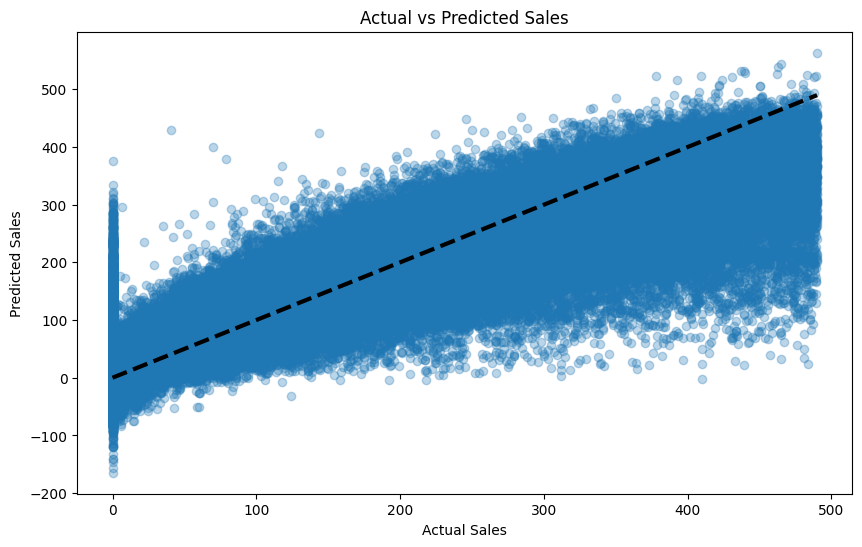

In [23]:
# Predict on validation set
val_predictions = model.predict(X_val)

# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=3)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


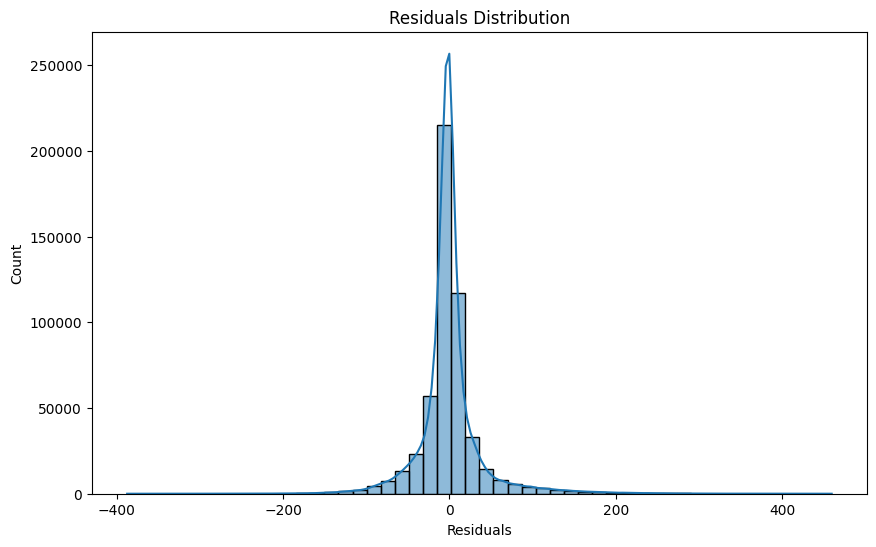

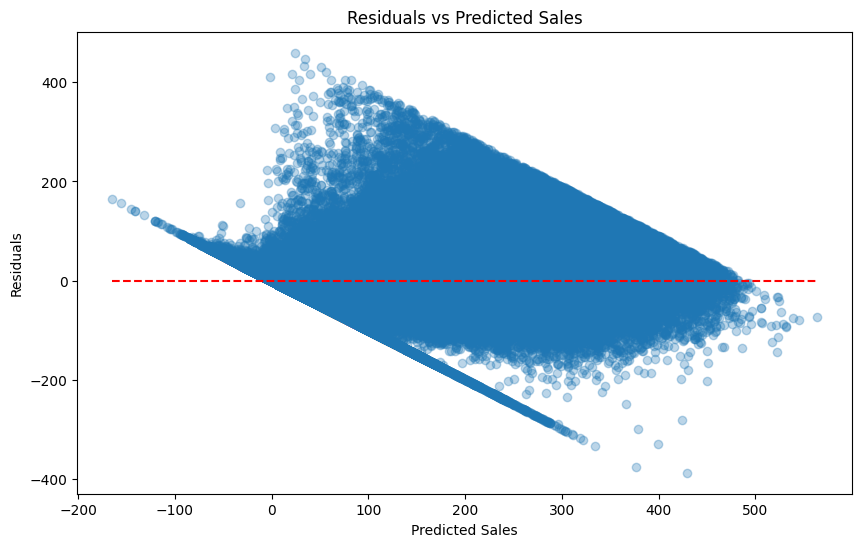

In [24]:
# Calculate residuals
residuals = y_val - val_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(val_predictions, residuals, alpha=0.3)
plt.hlines(y=0, xmin=val_predictions.min(), xmax=val_predictions.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


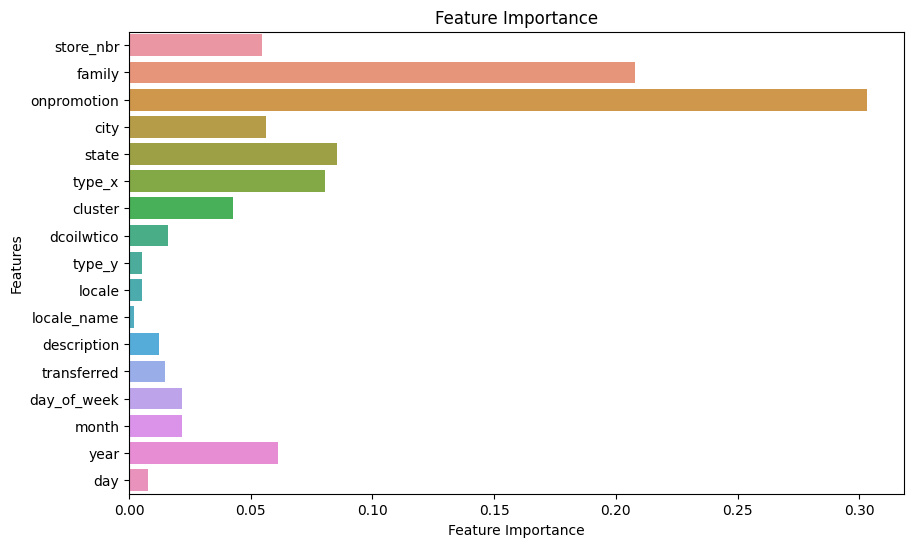

In [25]:
# Get feature importance
importance = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


In [26]:
# Predict on the test dataset
test_predictions = model.predict(test[features])

# Create a DataFrame with the predictions
submission = pd.DataFrame({
    'id': test['id'],
    'sales': test_predictions
})

In [27]:
# Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)